# Chainer を利用したMNIST手書き文字認識のデモ

## 主なDeep Learning フレームワークの種類

厳密にいうと、Deep Leanrning 専用のものではありません。

| ライブラリ名 | 公開時期(年) | 言語 | 開発元 |
|:--:|:--:|:--:|:--:|
| Theano | 2010 | Python | モントリオール大学 |
| Torch7 | 2011 | Lua | ニューヨーク大学 |
| Pylearn2 | 2013 | Python | モントリオール大学 |
| Caffe | 2013 | C++, Python | カリフォルニア大学バークレー校 |
| Chainer | 2015 | Python | Preferred Networks(PFN) |
| TensorFlow | 2015 | C++, Python | Google |


## Import

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import time
import seaborn as sns

In [2]:
import numpy as np
import chainer
from chainer import cuda, Function, gradient_check, Variable, optimizers, serializers, utils
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer import training
from chainer.training import extensions


In [12]:
chainer.__version__

'1.11.0'

## Multi-layer Perceptron on MNIST

In [3]:
import data
mnist = data.load_mnist_data()

In [4]:
print('画像数: {0}枚, 1つの画像あたりのピクセル数: {1} → 事例数: {0}例, {1}次元'.format(mnist['data'].shape[0], mnist['data'].shape[1]))

画像数: 70000枚, 1つの画像あたりのピクセル数: 784 → 事例数: 70000例, 784次元


### Display Data

1番目の画像の数字: 5


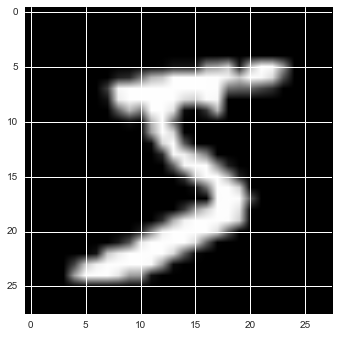

data[0]=[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   3  18  18  18 126 136 175  26 166 255
 247 127   0   0   0   0   0   0   0   0   0   0   0   0  30  36  94 154
 170 253 253 253 253 253 225 172 253 242 195  64   0   0   0   0   0   0
   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251  93  82
  82  56  39   0   0   0   0   0   0   0   0   0   0   0   0  18 219 253
 253 253 253 253 198 182 247 241   0   0   

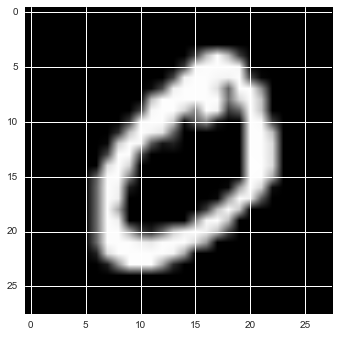

data[1]=[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0  51 159 253 159  50   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0  48 238 252 252 252 237   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0  54 227 253 252 239 233 252  57   6   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0  10  60 224 252 253 252 202  84 252
 253 122   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0 163 252 252 252 253 252 252  96 189 25

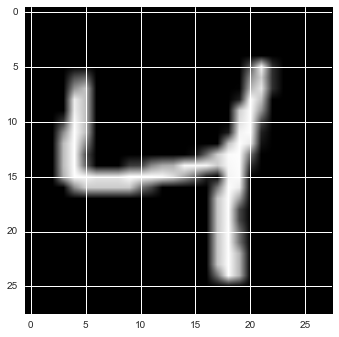

data[2]=[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  67 232
  39   0   0   0   0   0   0   0   0   0  62  81   0   0   0   0   0   0
   0   0   0   0   0   0   0   0 120 180  39   0   0   0   0   0   0   0
   0   0 126 163   0   0   0   0   0   0   0   0   0   0   0   0   0   2
 153 210  40   0   0   0   0   0   0   0   0   0 220 163   0   0   0   0
   0   0   0   0   0   0   0   0   0  27 25

In [5]:
import matplotlib.cm as cm

for idx in range(0,3):
    print('{0}番目の画像の数字: {1}'.format(idx+1, mnist['target'][idx]))
    img = mnist['data'][idx].reshape(28,28)
    plt.imshow(img, cmap = cm.Greys_r)
    plt.show()
    print('data[{0}]={1}'.format(idx, mnist['data'][idx]))

### Chain

```
----------- IN  -----------
ooo...ooo...(784)...ooo...ooo
      VVVVVVVVVVVVVVVVV
      ooo...(100)...ooo
      VVVVVVVVVVVVVVVVV
      ooo...(100)...ooo
         VVVVVVVVVV
         oooooooooo
----------- OUT -----------
```


In [8]:
class MLP(Chain):
    def __init__(self, train=True):
        super(MLP, self).__init__(
            l1=L.Linear(784, 100),
            l2=L.Linear(100, 100),
            l3=L.Linear(100, 10),
        )
        self.train = train

    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        y = self.l3(h2)
        return y

## Learning


In [9]:
model = L.Classifier(MLP())
optimizer = chainer.optimizers.Adam()
optimizer.setup(model)

train, test = chainer.datasets.get_mnist()  # Data set
train_iter = chainer.iterators.SerialIterator(train, 1000)
test_iter = chainer.iterators.SerialIterator(test, 1000,repeat=False, shuffle=False)

updater = training.StandardUpdater(train_iter, optimizer, device=-1)
trainer = training.Trainer(updater, (20, 'epoch'), out="result")
trainer.extend(extensions.Evaluator(test_iter, model, device=-1))
trainer.extend(extensions.LogReport(log_name='log'))
trainer.extend(extensions.PrintReport( ['epoch', 'main/loss', 'validation/main/loss', 'main/accuracy', 'validation/main/accuracy']))
# trainer.extend(extensions.ProgressBar())

trainer.run()

epoch       main/loss   validation/main/loss  main/accuracy  validation/main/accuracy
1           0.879983    0.330882              0.767767       0.9058                    
2           0.291618    0.253285              0.916467       0.9278                    
3           0.225925    0.206201              0.935883       0.9406                    
4           0.18349     0.174737              0.948          0.9476                    
5           0.154455    0.152678              0.956517       0.9555                    
6           0.133414    0.136996              0.962          0.9592                    
7           0.117159    0.12541               0.966783       0.9633                    
8           0.104419    0.116122              0.970067       0.9654                    
9           0.0939429   0.109378              0.972967       0.9678                    
10          0.0851937   0.104022              0.9755         0.9693                    
11          0.0776714   0.0998935 

In [10]:
import pandas as pd

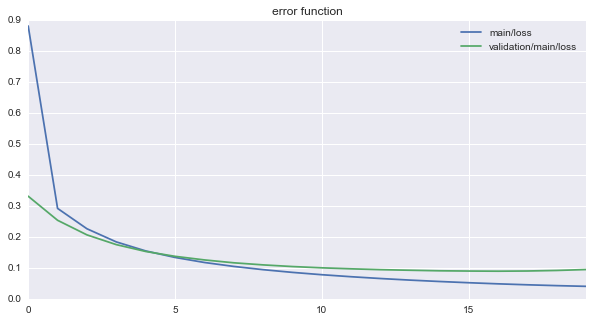

In [11]:
df = pd.read_json('./result/log')
df[['main/loss', 'validation/main/loss']].plot(figsize=(10, 5), title="error function")